Order Predition
===

Subject
---
In this competition, you're challenged to use **reservation** and **visitation** data to predict the total number of visitors to a restaurant for future dates. This information will help restaurants be much more efficient and allow them to focus on creating an enjoyable dining experience for their customers.

Evaluation
---
Description
Evaluation
Prizes
Timeline
Submissions are evaluated on the root mean squared logarithmic error.

The RMSLE is calculated as

$$\sqrt{\frac{1}{n} \sum_{i=1}^n (\log(p_i + 1) - \log(a_i+1))^2 },$$
where:

1. \\(n\\) is the total number of observations 
2. \\(p_i\\) is your prediction of visitors
3. \\(a_i\\) is the actual number of visitors 
4. \\(\log(x)\\) is the natural logarithm of \\(x\\)

Submission File
---
For every store and date combination in the test set, submission files should contain two columns: *id* and *visitors*.  The *id* is formed by concatenating the air_store_id and *visit_date* with an underscore. The file should contain a header and have the following format:
```
id,visitors
air_00a91d42b08b08d9_2017-04-23,0  
air_00a91d42b08b08d9_2017-04-24,0  
air_00a91d42b08b08d9_2017-04-25,0  
etc.
```
Timeline
---

1. January 30, 2018 - Entry deadline. You must accept the competition rules before this date in order to compete.
- January 30, 2018 - Team Merger deadline. This is the last day participants may join or merge teams.
- February 6, 2018 - Final submission deadline.


Data Description
---
Data Description
In this competition, you are provided a time-series forecasting problem centered around restaurant visitors. The data comes from two separate sites:

- Hot Pepper Gourmet (hpg): similar to Yelp, here users can search restaurants and also make a reservation online
- AirREGI / Restaurant Board (air): similar to Square, a reservation control and cash register system

You must use the reservations, visits, and other information from these sites to forecast future restaurant visitor totals on a given date. 

1. **The training data covers the dates from 2016 until April 2017. **
- **The test set covers the last week of April and May of 2017. **

The test set is split based on time (the public fold coming first, the private fold following the public) and covers a chosen subset of the air restaurants. Note that the test set intentionally spans a holiday week in Japan called the "Golden Week."

There are days in the test set where the restaurant were closed and had no visitors. These are ignored in scoring. The training set omits days where the restaurants were closed.

File Descriptions
---
This is a relational dataset from two systems. Each file is prefaced with the source (either air_ or hpg_) to indicate its origin. Each restaurant has a unique air_store_id and hpg_store_id. Note that not all restaurants are covered by both systems, and that you have been provided data beyond the restaurants for which you must forecast. Latitudes and Longitudes are not exact to discourage de-identification of restaurants.

air_reserve.csv

    This file contains reservations made in the air system. Note that the reserve_datetime indicates the time when the reservation was created, whereas the visit_datetime is the time in the future where the visit will occur.

      air_store_id - the restaurant's id in the air system
      visit_datetime - the time of the reservation
      reserve_datetime - the time the reservation was made
      reserve_visitors - the number of visitors for that reservation

hpg_reserve.csv

    This file contains reservations made in the hpg system.

      hpg_store_id - the restaurant's id in the hpg system
      visit_datetime - the time of the reservation
      reserve_datetime - the time the reservation was made
      reserve_visitors - the number of visitors for that reservation

air_store_info.csv

    This file contains information about select air restaurants. Column names and contents are self-explanatory.

      air_store_id
      air_genre_name
      air_area_name
      latitude
      longitude

   Note: latitude and longitude are the latitude and longitude of the area to which the store belongs

hpg_store_info.csv

    This file contains information about select hpg restaurants. Column names and contents are self-explanatory.

     hpg_store_id
     hpg_genre_name
     hpg_area_name
     latitude
     longitude
    Note: latitude and longitude are the latitude and longitude of the area to which the store belongs

store_id_relation.csv

    This file allows you to join select restaurants that have both the air and hpg system.

      hpg_store_id
      air_store_id
  
air_visit_data.csv

    This file contains historical visit data for the air restaurants.

      air_store_id
      visit_date - the date
      visitors - the number of visitors to the restaurant on the date

sample_submission.csv

    This file shows a submission in the correct format, including the days for which you must forecast.

      id - the id is formed by concatenating the air_store_id and visit_date with an underscore
      visitors- the number of visitors forecasted for the store and date combination

date_info.csv

     This file gives basic information about the calendar dates in the dataset.

       calendar_date
       day_of_week
       holiday_flg - is the day a holiday in Japan

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mpl_toolkits
from pandas import Series
from sklearn.metrics import mean_squared_error
from math import sqrt

%matplotlib inline

In [17]:
import qgrid

import warnings
warnings.filterwarnings('ignore')

In [5]:
hpg_data = pd.read_csv("data/hpg_store_info.csv")

In [4]:
air_data = pd.read_csv("data/air_store_info.csv")

In [23]:
air_reserve = pd.read_csv("data/air_reserve.csv")
hpg_reserve = pd.read_csv("data/hpg_reserve.csv")

store_id_relation = pd.read_csv("data/store_id_relation.csv")
air_visit_data = pd.read_csv("data/air_visit_data.csv")

In [21]:
air_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 829 entries, 0 to 828
Data columns (total 5 columns):
air_store_id      829 non-null object
air_genre_name    829 non-null object
air_area_name     829 non-null object
latitude          829 non-null float64
longitude         829 non-null float64
dtypes: float64(2), object(3)
memory usage: 32.5+ KB


In [24]:
air_visit_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252108 entries, 0 to 252107
Data columns (total 3 columns):
air_store_id    252108 non-null object
visit_date      252108 non-null object
visitors        252108 non-null int64
dtypes: int64(1), object(2)
memory usage: 5.8+ MB


In [32]:
air_visit_data.tail()

,air_store_id,visit_date,visitors
252103,air_24e8414b9b07decb,2017-04-18,6
252104,air_24e8414b9b07decb,2017-04-19,6
252105,air_24e8414b9b07decb,2017-04-20,7
252106,air_24e8414b9b07decb,2017-04-21,8
252107,air_24e8414b9b07decb,2017-04-22,5


In [18]:
qgrid.show_grid(air_data)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defaultColumnWidth': 150, 'rowHeight': 28, 'enableColumnReorder': False, 'enableTextSelectionOnCells': True, 'editable': True, 'autoEdit': False, 'explicitInitialization': True, 'maxVisibleRows': 15, 'minVisibleRows': 8}, precision=5)

In [25]:
qgrid.show_grid(air_visit_data)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defaultColumnWidth': 150, 'rowHeight': 28, 'enableColumnReorder': False, 'enableTextSelectionOnCells': True, 'editable': True, 'autoEdit': False, 'explicitInitialization': True, 'maxVisibleRows': 15, 'minVisibleRows': 8}, precision=5)

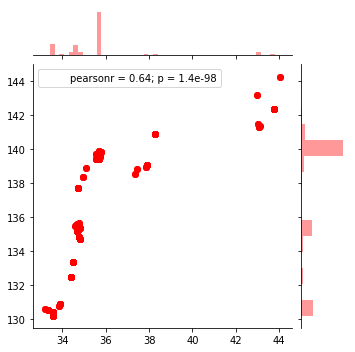

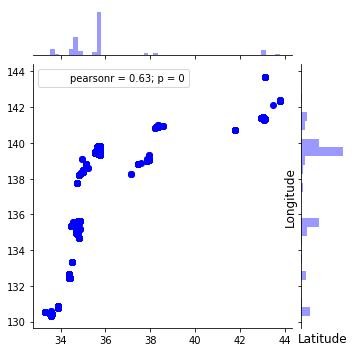

In [15]:
plt.figure(figsize=(10,10))
sns.jointplot(x=air_data.latitude.values, y=air_data.longitude.values, size=5,color="red")
sns.jointplot(x=hpg_data.latitude.values, y=hpg_data.longitude.values, size=5,color="blue")

plt.ylabel('Longitude', fontsize=12)
plt.xlabel('Latitude', fontsize=12)
#plt1 = plt()
sns.despine;

In [49]:
air_visit_data1=air_visit_data[['visit_date','visitors']]
air_visit_data1.to_csv('data/air_visit_data1.csv',index=False)
series = Series.from_csv('data/air_visit_data1.csv')


In [76]:

# load data
series = Series.from_csv('data/air_visit_data1.csv')
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# predict
	yhat = history[-1]
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
	#print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

RMSE: 15.774


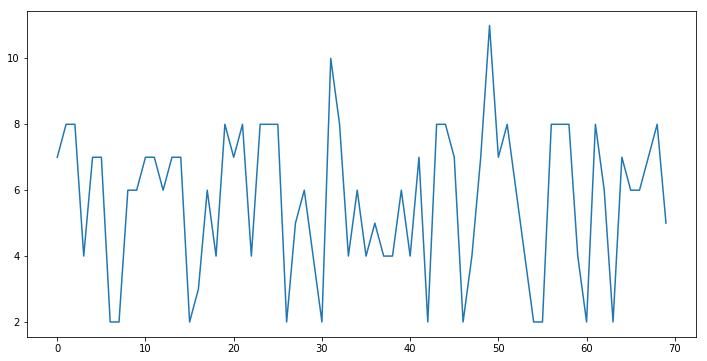

In [75]:
plt.figure(figsize=(12,6))
plt.plot(X[-70:])


In [78]:
from statsmodels.tsa.stattools import adfuller


ADF Statistic: -64.177310
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567


NameError: name 'pyplot' is not defined

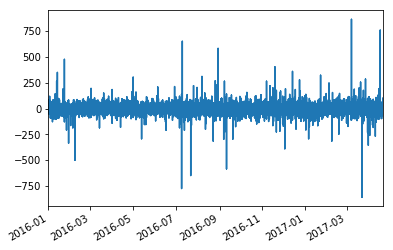

In [79]:

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)
#series = Series.from_csv('data/air_visit_data1.csv')
#series = Series.from_csv('csv/dataset.csv')
X = series.values
X = X.astype('float32')
# difference data
months_in_year = 12
stationary = difference(X, months_in_year)
stationary.index = series.index[months_in_year:]
# check if stationary
result = adfuller(stationary)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))
# save
stationary.to_csv('data/stationary.csv')
# plot
stationary.plot()


The results show that the test statistic value -64.177310 is smaller than the critical value at 1% of -3.340. This suggests that we can reject the null hypothesis with a significance level of less than 1%

KeyboardInterrupt: 

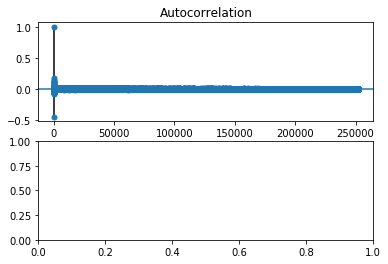

In [82]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

series = Series.from_csv('data/stationary.csv')
plt.figure()
plt.subplot(211)
plot_acf(series, ax=plt.gca())

plt.subplot(212)
plot_pacf(series, ax=plt.gca())


In [2]:
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from math import sqrt
 

/Users/cch/anaconda36/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [8]:
series

2016-01-13    25
2016-01-14    32
2016-01-15    29
2016-01-16    22
2016-01-18     6
2016-01-19     9
2016-01-20    31
2016-01-21    21
2016-01-22    18
2016-01-23    26
2016-01-25    21
2016-01-26    11
2016-01-27    24
2016-01-28    21
2016-01-29    26
2016-01-30     6
2016-02-03    18
2016-02-04    12
2016-02-05    45
2016-02-06    15
2016-02-08    19
2016-02-09    15
2016-02-10    32
2016-02-11     3
2016-02-12    26
2016-02-13     8
2016-02-15    14
2016-02-16    15
2016-02-17    17
2016-02-18    22
              ..
2017-03-06     2
2017-03-07    10
2017-03-08     8
2017-03-09     4
2017-03-10     6
2017-03-11     4
2017-03-13     5
2017-03-14     4
2017-03-15     4
2017-03-16     6
2017-03-17     4
2017-03-18     7
2017-03-21     2
2017-03-22     8
2017-03-23     8
2017-03-24     7
2017-03-25     2
2017-03-27     4
2017-03-28     7
2017-03-29    11
2017-03-30     7
2017-03-31     8
2017-04-01     6
2017-04-03     4
2017-04-04     2
2017-04-05     2
2017-04-06     8
2017-04-07    

In [30]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]
 
 
# load data
series = Series.from_csv('data/air_visit_data1.csv')
series=series[-100:]
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    
    # difference data
    months_in_year = 7
    diff = difference(history, months_in_year)
    #print(diff)
    # predict
    model = ARIMA(diff, order=(2,2,0))
    model_fit = model.fit( trend='nc', disp=0)
    yhat = model_fit.forecast()[0]
    yhat = inverse_difference(history, yhat, months_in_year)
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)
    #print('>Predicted=%d, Expected=%3.f' % (int(yhat), obs))
# report performance
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

RMSE: 5.499


In [40]:
import warnings

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return numpy.array(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]
 
# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.50)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        # difference data
        months_in_year = 7
        diff = difference(history, months_in_year)
        model = ARIMA(diff, order=arima_order)
        model_fit = model.fit(trend='nc', disp=0)
        yhat = model_fit.forecast()[0]
        yhat = inverse_difference(history, yhat, months_in_year)
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    mse = mean_squared_error(test, predictions)
    rmse = sqrt(mse)
    return rmse
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s RMSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
 
# load dataset
series = Series.from_csv('data/air_visit_data1.csv')
series = series[-100:]
# evaluate parameters
p_values = range(0, 3)
d_values = range(0, 4)
q_values = range(0, 2)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)


ARIMA(0, 0, 1) RMSE=3.180
ARIMA(0, 1, 1) RMSE=3.201
ARIMA(0, 2, 1) RMSE=4.361
ARIMA(1, 0, 0) RMSE=3.184
ARIMA(1, 1, 0) RMSE=4.003
ARIMA(1, 2, 0) RMSE=5.727
ARIMA(2, 0, 0) RMSE=3.175
ARIMA(2, 0, 1) RMSE=3.058
ARIMA(2, 1, 0) RMSE=3.906
ARIMA(2, 2, 0) RMSE=5.499
Best ARIMA(2, 0, 1) RMSE=3.058


In [38]:
import numpy
evaluate_arima_model(series, [2,0,0])

3.175092090917555

RMSE: 3.058
               0
count  50.000000
mean   -0.205496
std     3.082530
min    -6.686005
25%    -1.812576
50%    -0.186692
75%     1.374952
max     8.813310


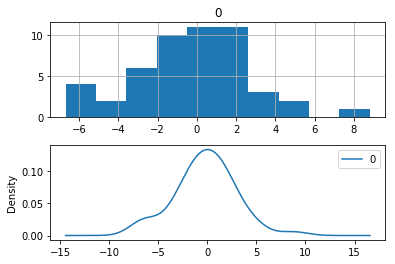

In [49]:
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# difference data
	months_in_year = 7
	diff = difference(history, months_in_year)
	# predict
	model = ARIMA(diff, order=(2,0,1))
	model_fit = model.fit(trend='nc', disp=0)
	yhat = model_fit.forecast()[0]
	yhat = inverse_difference(history, yhat, months_in_year)
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)    
    
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = pd.DataFrame(residuals)
print(residuals.describe())
# plot
plt.figure()
plt.subplot(211)
residuals.hist(ax=plt.gca())
plt.subplot(212)
residuals.plot(kind='kde', ax=plt.gca())


RMSE: 3.052


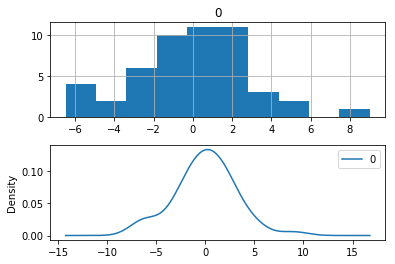

In [50]:
bias = -0.205496

X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()

for i in range(len(test)):
	# difference data
	months_in_year = 7
	diff = difference(history, months_in_year)
	# predict
	model = ARIMA(diff, order=(2,0,1))
	model_fit = model.fit(trend='nc', disp=0)
	yhat = model_fit.forecast()[0]
	yhat = bias + inverse_difference(history, yhat, months_in_year)
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
# report performance
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = pd.DataFrame(residuals)
# plot
plt.figure()
plt.subplot(211)
residuals.hist(ax=plt.gca())
plt.subplot(212)
residuals.plot(kind='kde', ax=plt.gca())


In [52]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

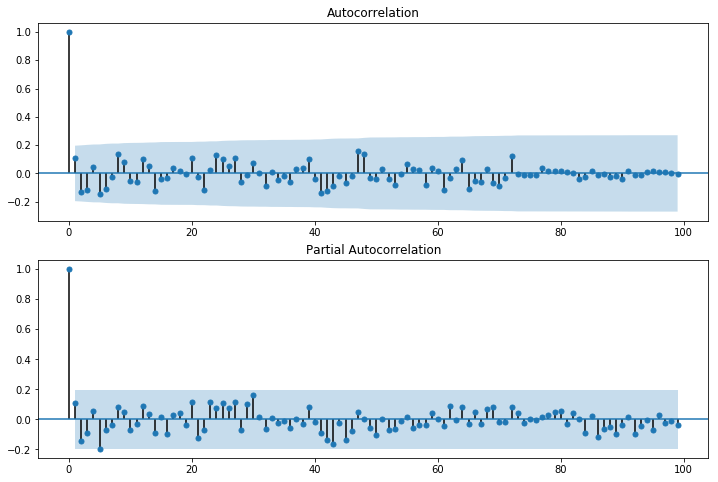

In [53]:
plt.figure(figsize=(12,8))
plt.subplot(211)
plot_acf(series, ax=plt.gca())
plt.subplot(212)
plot_pacf(series, ax=plt.gca())
plt.show()

In [56]:
model_fit.save('data/model.pkl')
numpy.save('data/model_bias.npy', [bias])

In [58]:
from statsmodels.tsa.arima_model import ARIMAResults

In [59]:
months_in_year = 7
model_fit = ARIMAResults.load('data/model.pkl')
bias = numpy.load('data/model_bias.npy')
yhat = float(model_fit.forecast()[0])
yhat = bias + inverse_difference(series.values, yhat, months_in_year)
print('Predicted: %.3f' % yhat)

Predicted: 1.319


NameError: name 'y' is not defined

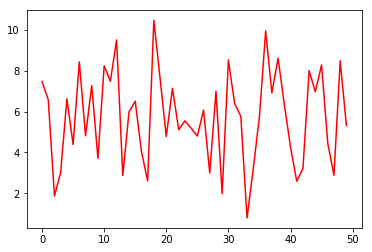

In [55]:
plt.plot(predictions, color='red')
plt.plot(y, color='blue')